<a href="https://colab.research.google.com/github/ADIthaker/CNN-Techniques/blob/master/DeepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import *

In [14]:
class DeepDreamer(object):
  def __init__(self, octave_scale=1.30, octave_power_factors=None, layers=None):
    self.octave_scale = octave_scale
    if octave_power_factors is None:
      self.octave_power_factors = [*range(-2, 3)]
    else:
      self.octave_power_factors = octave_power_factors
    if layers is None:
      self.layers = ['mixed3', 'mixed5']
    else:
      self.layers = layers
    self.base_model = InceptionV3(weights='imagenet', include_top=False)
    outputs = [self.base_model.get_layer(name).output for name in self.layers]
    self.dreamer_model = Model(self.base_model.input, outputs)
  
  def _calculate_loss(self, image):
    image_batch = tf.expand_dims(image, axis=0)
    activations = self.dreamer_model(image_batch)
    if len(activations) == 1:
      activations = [activations]
    losses = []
    for activation in activations:
      loss = tf.math.reduce_mean(activation)
      losses.append(loss)

    total_loss = tf.reduce_sum(losses)
    return total_loss
  
  @tf.function
  def _gradient_ascent(self, image, steps, step_size):
    loss = tf.constant(0.0)
    for _ in range(steps):
      with tf.GradientTape() as tape:
        tape.watch(image)
        loss = self._calculate_loss(image)
      gradients = tape.gradient(loss, image)
      gradients /= tf.math.reduce_std(gradients) + 1e-8
      image = image + gradients*step_size
      image = tf.clip_by_value(image, -1, 1)
    return loss, image
  
  def _deprocess(self, image):
    image = 255 * (image +1.0) / 2.0
    image = tf.cast(image, tf.uint8)
    image = np.array(image)
    return image
  
  def _dream(self, image, steps, step_size):
    image = preprocess_input(image)
    image = tf.convert_to_tensor(image)
    step_size = tf.convert_to_tensor(step_size)
    step_size = tf.constant(step_size)
    steps_remaining = steps

    current_steps = 0
    while steps_remaining > 0:
      if steps_remaining > 100:
        run_steps = tf.constant(100)
      else:
        run_steps = tf.constant(steps_remaining)
      steps_remaining -= run_steps
      current_steps += run_steps
      loss, image = self._gradient_ascent(image, run_steps, step_size)

    result = self._deprocess(image)
    return result
  def dream(self, image, steps=100, step_size=0.01):
    image = tf.constant(np.array(image))
    base_shape = tf.shape(image)[:-1]
    base_shape = tf.cast(base_shape, tf.float32)

    for factor in self.octave_power_factors:
      new_shape = tf.cast(base_shape*(self.octave_scale**factor), tf.int32)
      image = tf.image.resize(image,new_shape).numpy()
      image = self._dream(image, steps=steps, step_size=step_size)
    base_shape = tf.cast(base_shape, tf.int32)
    image = tf.image.resize(image, base_shape)
    image = tf.image.convert_image_dtype(image / 255.0, dtype=tf.uint8)
    image = np.array(image)
    return np.array(image)

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import *

In [4]:
def load_image(image_path):
  image = load_img(image_path)
  image = img_to_array(image)
  return image

In [5]:
def show_image(image):
  plt.imshow(image)
  plt.show()

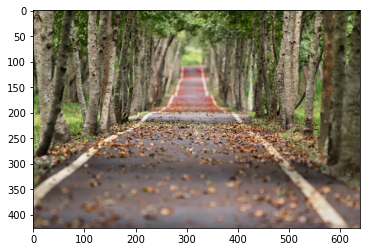

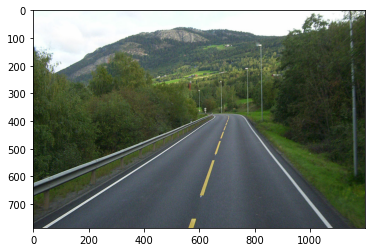

In [6]:
im_1 = load_image('road.jpg')
im_2 = load_image('road2.jpg')
show_image(im_1/255.0)
show_image(im_2/255.0)

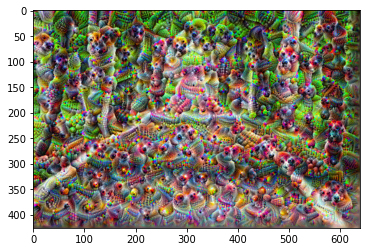

In [15]:
dreamy_im_1 = DeepDreamer().dream(im_1)
show_image(dreamy_im_1)

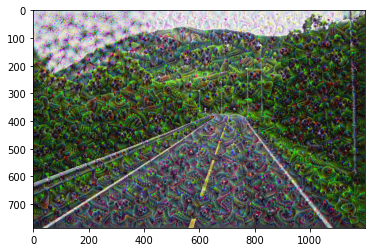

In [16]:
dreamy_im_2 = DeepDreamer().dream(im_2)
show_image(dreamy_im_2)